<a href="https://colab.research.google.com/github/pooja614/ML_DL_projects/blob/main/Time_series_of_Electric_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams 
# set plot size 
rcParams['figure.figsize'] = 10, 6 
# read data
folder_path = '/content/drive/MyDrive/ETE_projects/time_series/'
df = pd.read_csv(folder_path+ 'Electric_Production.csv') 
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [10]:
def visualization(data):
  print(data.info())
  print('-------------------------------------------------------')
  print(data.shape)
  print('-------------------------------------------------------')
  print(data.isnull().sum()) 

visualization(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB
None
-------------------------------------------------------
(397, 2)
-------------------------------------------------------
DATE          0
IPG2211A2N    0
dtype: int64


In [43]:
df['DATE'] = pd.to_datetime(df.DATE)
# df.reset_index(inplace = True)
df = df.set_index(df.DATE) 
df.drop('DATE', axis=1, inplace=True)
print(df.dtypes)  
df.head() 

IPG2211A2N    float64
dtype: object


,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [21]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


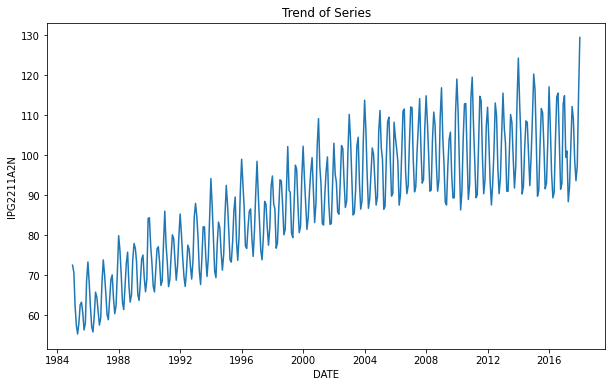

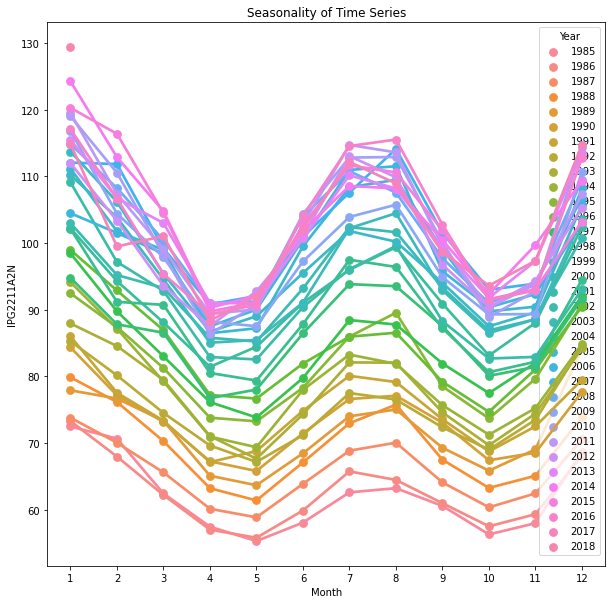

In [47]:
## Time series Characteristics 

def characteristics(data, x, y, title):
  plt.figure(figsize = (10,6)) 
  plt.plot(data)
  plt.xlabel(x) 
  plt.ylabel(y)
  plt.title(title) 

  df_temp = data.copy()
  df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year 
  df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month 
  # Stacked Line Plot 
  plt.figure(figsize=(10,10)) 
  plt.title('Seasonality of Time Series')
  sns.pointplot(x='Month', y= 'IPG2211A2N', hue='Year', data = df_temp) 

characteristics(df, 'DATE', 'IPG2211A2N','Trend of Series') 

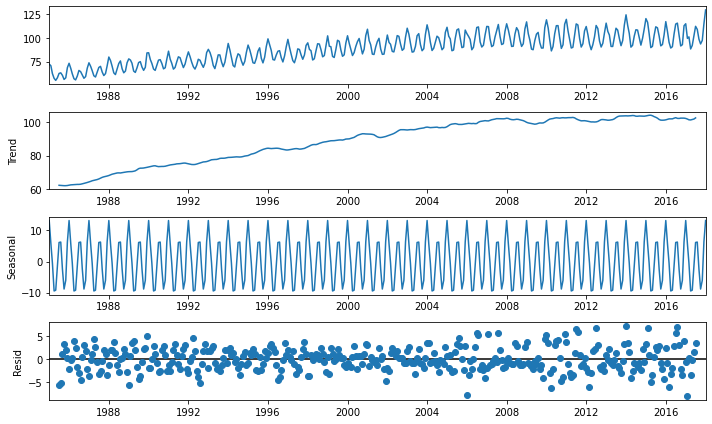

In [48]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive') 
fig = decomposition.plot()

In [50]:
def stationarity_test(data, window):
  rolling_mean = data.rolling(window = window).mean()
  rolling_std = data.rolling(window=window).std() 
  return rolling_mean, rolling_std 

def plot_rolling_static(data, r_mean, r_std, x, y, title): 
  plt.figure(figsize=(10,6))
  plt.xlabel(x)                    
  plt.ylabel(y)
  plt.title(title)
  plt.plot(data, color='blue', label = 'Original')
  plt.plot(r_mean, color='green', label='Rolling Mean')
  plt.plot(r_std, color='red', label='Rolling Std') 
  plt.legend() 
  plt.show()

def Dickey_Fuller_test(data):
  df_test = adfuller(data)
  df_output = pd.Series(df_test[0:4], index=['Critical Value',
                                             'p-value',
                                             'Lags used for t-statistic',
                                             'No_of_observation_used']) 
  for key, value in df_test[4].items():
    df_output['Critical value(%s)'%key] = value 
  print(df_output)

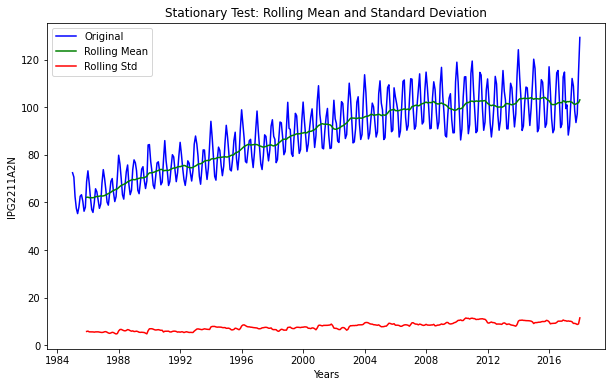

Critical Value                -2.256990
p-value                        0.186215
Lags used for t-statistic     15.000000
No_of_observation_used       381.000000
Critical value(1%)            -3.447631
Critical value(5%)            -2.869156
Critical value(10%)           -2.570827
dtype: float64


In [51]:
r_mean, r_std = stationarity_test(df, 12)
plot_rolling_static(df, r_mean, r_std, 'Years', 'IPG2211A2N', 
                    'Stationary Test: Rolling Mean and Standard Deviation')
Dickey_Fuller_test(df) 

<pre>
<b>Rolling Statistics</b>:
Standard deviation has less variation but mean is increasing continuously.
<b>Critical Value  -2.256990 </b>: Critical value of the data
<b>p-value  0.186215</b>: Probability that null hypothesis will not be rejected. 
<b>t-statistic_Lag 15.000000</b>: Number of lags used in regression to determine t-statistic. So there are no auto correlations going back to '0' periods here.
No_of_observation_used  381.000000 : Number of observations used in the analysis.
 
Critical value(1%)            -3.447631
Critical value(5%)            -2.869156
Critical value(10%)           -2.570827
 
T values corresponding to adfuller test.
Since critical value -2.25>-3.44,-2.86,-2.57 (t-values at 1%,5%and 10% confidence intervals), null hypothesis cannot be rejected. 
So there is non stationarity in the data. 
Also p-value of 0.18>0.05(if we take 5% significance level or 95% confidence interval), null hypothesis cannot be rejected. 
Hence data is non stationary (that means it has relation with time) 
</pre>


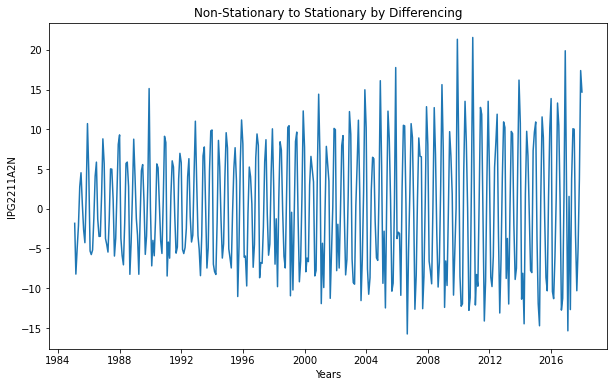

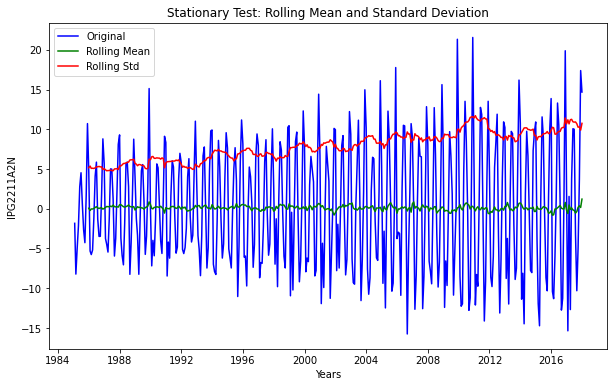

Critical Value              -7.104891e+00
p-value                      4.077787e-10
Lags used for t-statistic    1.400000e+01
No_of_observation_used       3.810000e+02
Critical value(1%)          -3.447631e+00
Critical value(5%)          -2.869156e+00
Critical value(10%)         -2.570827e+00
dtype: float64


In [52]:
## Converting Non-Stationary Data into Stationary Data 
# Differencing 

def differencing(data,x,y,title):
  df_diff = data.diff(periods=1) 
  plt.xlabel(x) 
  plt.ylabel(y)
  plt.title(title)
  plt.plot(df_diff) 
  
  return df_diff 

df_diff = differencing(df,'Years', 'IPG2211A2N','Non-Stationary to Stationary by Differencing' ) 
df_diff.dropna(inplace=True) 
rd_mean, rd_std = stationarity_test(df_diff, 12) 
plot_rolling_static(df_diff, rd_mean, rd_std, 'Years', 'IPG2211A2N', 
                    'Stationary Test: Rolling Mean and Standard Deviation')
Dickey_Fuller_test(df_diff) 


* There is slight upward trend in standard deviation. 
* Criticl Value is less than (1%, 5%, 10%) critical.  
* p-value is lesser than 0.05. 
Thus it is stationary series. 

References: 
https://www.kaggle.com/code/satishgunjal/tutorial-time-series-analysis-and-forecasting/notebook 


To be continued. 